# DOS Plotting for g-BC3

Electronic density versus energy

## Electronic density versus energy

In the file `SUMMARY.fcc`

+ The 1st column: lattice parameter (in Å units)
+ The 2nd column: unit number (always 1 in this case)
+ The 3rd column: free energy (in eV units)
+ The 4th column: initial energy (in eV units)
+ The 5th column: energy change (difference between initial and current energy, in eV units)

In [1]:
#### Declarations of process functions for DOS with vectorized programming

### Necessary packages invoking
import numpy as np
import xml.etree.ElementTree as ET

### Extract DOS from vasprun.xml
def extract_dos_vectorized(file_path):
    # Analysis vasprun.xml file
    tree = ET.parse(file_path)
    root = tree.getroot()

    ## Extract Fermi energy
    efermi_element = root.find(".//dos/i[@name='efermi']")
    efermi = float(efermi_element.text.strip())

    ## Extract the number of ions
    first_positions = root.find(".//varray[@name='positions'][1]")
    positions_concatenated_text = " ".join([position.text for position in first_positions.findall("v")])
    positions_array = np.fromstring(positions_concatenated_text, sep=" ")
    positions_matrix = positions_array.reshape(-1, 3)
    ions_number = positions_matrix.shape[0]

    ## Extract the number of kpoints
    kpointlist = root.find(".//varray[@name='kpointlist']")
    kpointlist_concatenated_text = " ".join([kpointlist.text for kpointlist in kpointlist.findall("v")])
    kpointlist_array = np.fromstring(kpointlist_concatenated_text, sep=" ")
    kpointlist_matrix = kpointlist_array.reshape(-1, 3)
    kpoints_number = kpointlist_matrix.shape[0]

    ## Extract eigen, occupancy number
    for kpoints_index in range(1, kpoints_number+1):
        xpath_expr = f".//set[@comment='kpoint {kpoints_index}']"
        eigen_column = np.empty(0)
        occu_column  = np.empty(0)
        for eigen_occ_element in root.find(xpath_expr):
            values_eigen = list(map(float, eigen_occ_element.text.split()))
            eigen_var = values_eigen[0]
            eigen_column = np.append(eigen_column, eigen_var)
            occu_var = values_eigen[1]
            occu_column = np.append(occu_column, occu_var)
        if kpoints_index == 1 :
            eigen_matrix = eigen_column.reshape(-1, 1)
            occu_matrix = occu_column.reshape(-1, 1)
        else:
            eigen_matrix = np.hstack((eigen_matrix,eigen_column.reshape(-1, 1)))
            occu_matrix  = np.hstack((occu_matrix, occu_column.reshape(-1, 1)))
    # eigen_sum = np.sum(eigen_matrix, axis=1)
    # occu_sum  = np.sum(occu_matrix, axis=1)

    ## Extract energy, total DOS, and integrated DOS
    # lists initialization
    energy_dos_list     = np.empty(0)
    total_dos_list      = np.empty(0)
    integrated_dos_list = np.empty(0)
    path_dos = f".//total/array/set/set[@comment='spin 1']/r"
    for element_dos in root.findall(path_dos):
        values_dos = list(map(float, element_dos.text.split()))
        energy_dos_list = np.append(energy_dos_list, values_dos[0])
        total_dos_list = np.append(total_dos_list, values_dos[1])
        integrated_dos_list = np.append(integrated_dos_list, values_dos[2])
    shift = efermi
    energy_dos_shift = energy_dos_list - shift

    return (efermi, ions_number, kpoints_number, eigen_matrix, occu_matrix, energy_dos_shift, total_dos_list, integrated_dos_list)

efermi, ions_number, kpoints_number, eigen_sum, occu_sum, energy_dos_shift, total_dos_list, integrated_dos_list = extract_dos_vectorized("1_Lattice_Relaxation_gamma/vasprun.xml")



In [2]:
##### Process data

### File paths (you should update these to the correct file paths)
dos_file_path = "1_Lattice_Relaxation_gamma/vasprun.xml"

### Extract data
dos_result = extract_dos_vectorized(dos_file_path)
## Physical contents
efermi = dos_result[0]
ions_number = dos_result[1]
kpoints_number= dos_result[2] 
eigen_sum = dos_result[3] 
occu_sum = dos_result[4]
## DOS
energy_dos_shift = dos_result[5]
total_dos_list = dos_result[6]
integrated_dos_list = dos_result[7]

### Testing space
print(f"energy_dos_shift: {len(energy_dos_shift)} {energy_dos_shift}")
print(f"total_dos_list: {len(total_dos_list)} {total_dos_list}")
print(f"integrated_dos_list: {len(integrated_dos_list)}, {integrated_dos_list}")

energy_dos_shift: 301 [-17.66813262 -17.57443262 -17.48073262 -17.38713262 -17.29343262
 -17.19973262 -17.10603262 -17.01243262 -16.91873262 -16.82503262
 -16.73143262 -16.63773262 -16.54403262 -16.45033262 -16.35673262
 -16.26303262 -16.16933262 -16.07563262 -15.98203262 -15.88833262
 -15.79463262 -15.70103262 -15.60733262 -15.51363262 -15.41993262
 -15.32633262 -15.23263262 -15.13893262 -15.04533262 -14.95163262
 -14.85793262 -14.76423262 -14.67063262 -14.57693262 -14.48323262
 -14.38953262 -14.29593262 -14.20223262 -14.10853262 -14.01493262
 -13.92123262 -13.82753262 -13.73383262 -13.64023262 -13.54653262
 -13.45283262 -13.35913262 -13.26553262 -13.17183262 -13.07813262
 -12.98453262 -12.89083262 -12.79713262 -12.70343262 -12.60983262
 -12.51613262 -12.42243262 -12.32883262 -12.23513262 -12.14143262
 -12.04773262 -11.95413262 -11.86043262 -11.76673262 -11.67303262
 -11.57943262 -11.48573262 -11.39203262 -11.29843262 -11.20473262
 -11.11103262 -11.01733262 -10.92373262 -10.83003262 -

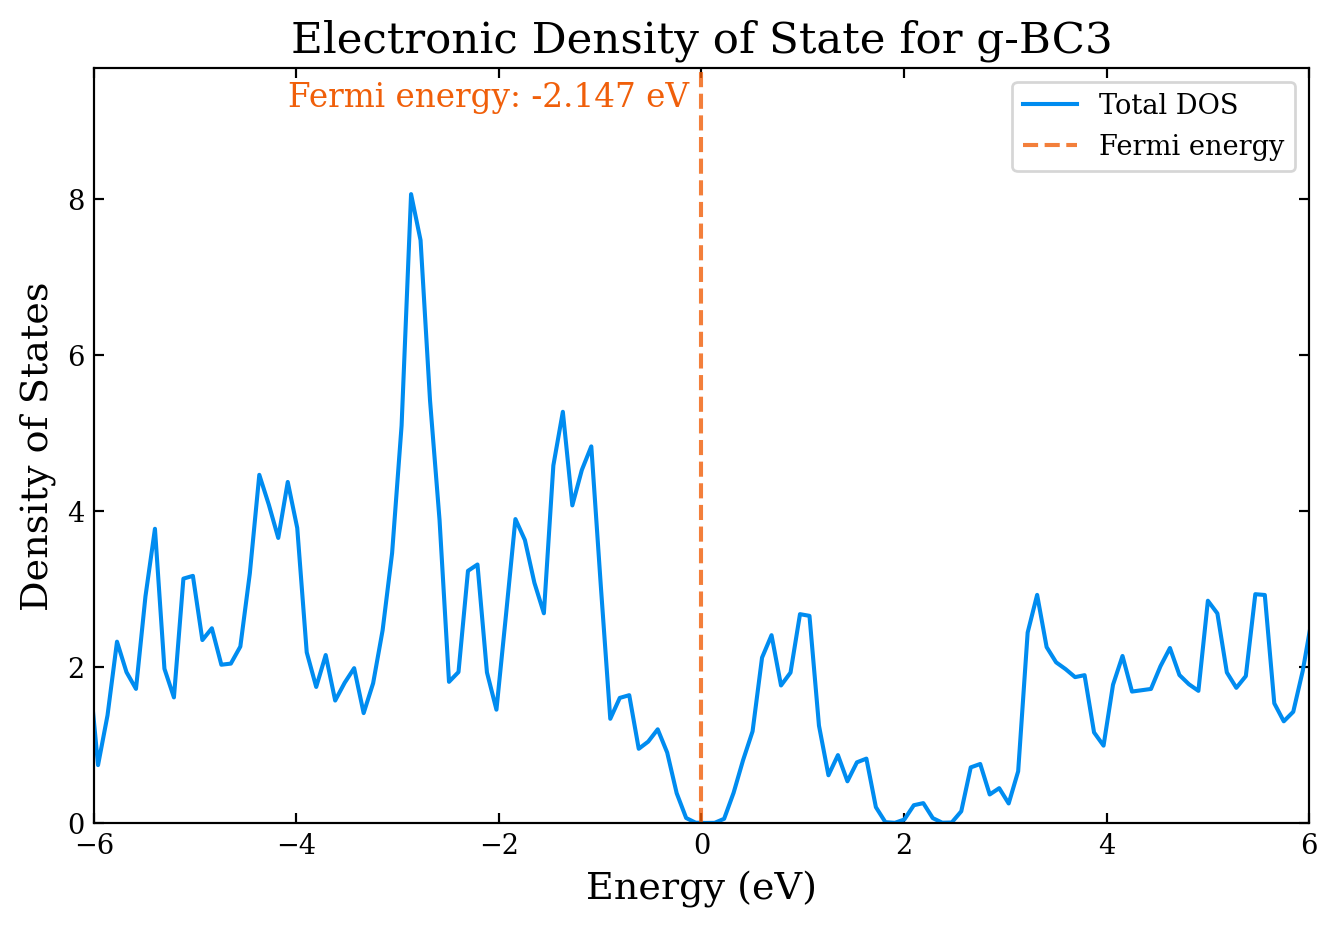

In [3]:
#### Ploting for DOS

### Import the necessary packages for plotting
import matplotlib.pyplot as plt

### Set up the specified style parameters
plt.figure(dpi=196, figsize=(8, 5))
params = {"text.usetex": False, "font.family": "serif", "mathtext.fontset": "cm", "axes.titlesize": 16, "axes.labelsize": 14, "figure.facecolor": "w"}
plt.rcParams.update(params)
plt.tick_params(direction="in", which="both", top=True, right=True, bottom=True, left=True)

### Title and labels
plt.title("Electronic Density of State for g-BC3"); plt.xlabel(r"Energy (eV)"); plt.ylabel(r"Density of States")

### Plot data
## Plot DOS data from vasprun.xml
y_axis_top = max(total_dos_list)
y_limit = y_axis_top * 1.2
x_range = 6

plt.plot(energy_dos_shift, total_dos_list, c="#008CF0", label="Total DOS")
# plt.plot(energies_shift, integrated_dos_list, c="#8C64F0", label="Integrated DOS"); y_axis_top = max(max(total_dos_list), max(integrated_dos_list))

# Plot Fermi energy as a vertical line
shift = efermi
plt.axvline(x = efermi-shift, linestyle="--", color="#F05F0A", alpha=0.8, label="Fermi energy")

# Add Fermi energy value to the plot
fermi_energy_text = f"Fermi energy: {efermi:.3f} eV"
plt.text(efermi-shift-x_range*0.02, y_limit*0.95, fermi_energy_text, fontsize=12, color="#F05F0A", rotation=0, ha="right")

plt.xlim(-x_range, x_range)
plt.ylim(0, y_limit)
plt.legend(loc="best")
plt.show()